# Characterizing offshore stability
Peter Kalverla, Oct 2017.

This work is inspired by the observation that strong wind shear and density stratification can be maintained simulataneously in offshore boundary layers (Kalverla, 2017a,b; Baas, 2017). For such conditions, the use of the Richardson number is misleading, as it classifies the boundary layer as (near-)neutral, whereas the flow is in fact very stratified. We start by considering the theoretical framework on which traditional stability measures are based. Thereafter, we proceed with an analysis of the TKE budget in WRF and a proposed research approach incorporating LES or possibly a simple theoretical model. 


## Theoretical framework

### The Richardson number
The prognostic equation for turbulent kinetic energy is

$$
\frac{\partial \overline{e}}{\partial t} 
+ \overline{U}_j \frac{\partial \overline{e}}{\partial x_j}
= \frac{g}{\overline{\theta}_v}\left(\overline{w'\theta_v'}\right)
- \overline{u_i'u_j'}\frac{\partial \overline{U_i}}{\partial x_j}
- \frac{\partial(\overline{u_j'e'})}{\partial x_j} 
- \frac{1}{\overline{\rho}}\frac{\partial(\overline{u_i'p'})}{\partial x_i}
- \epsilon
$$

A measure of stability that is often used in boundary-layer meteorology is the (flux) Richardson number. It is defined as the ratio of two important terms of the TKE-equation
$$
Ri_f = \frac{\frac{g}{\overline{\theta}_v}\left(\overline{w'\theta_v'}\right)}{\overline{u_i'u_j'}\frac{\partial \overline{U_i}}{\partial x_j}}
$$

which, by assuming horizontal homogeneity and neglecting subsidence reduces to

$$
Ri_f = \frac{\frac{g}{\overline{\theta}_v}\left(\overline{w'\theta_v'}\right)}{\overline{u'w'}\frac{\partial \overline{U}}{\partial z}+\overline{v'w'}\frac{\partial \overline{V}}{\partial z}}
$$

If the other terms of the TKE-equations are left aside for a moment, then the Ri indicates the relative strength of buoyancy and shear in producing and suppressing turbulence. A flow with Ri number larger than 1 is expected to become laminar, because the suppression by density stratification is stronger than the production by shear. However, the Ri number is undefined for laminar flow, because the turbulent fluxes expressed by the covariances will be absent in that case.

Adopting K-theory, the gradient Richardson number can be derived
$$
Ri_g = \frac{\frac{g}{\overline{\theta}_v}\frac{\partial \overline{\theta_v}}{\partial z}}{\left(\frac{\partial \overline{U}}{\partial z}\right)^2+\left(\frac{\partial \overline{V}}{\partial z}\right)^2}
$$

and if the gradients are approximated with bulk differences, we end up with the bulk Richardson number
$$
Ri_b = \frac{\frac{g}{\overline{\theta}_v} \Delta \overline{\theta_v} \Delta z}{\left(\Delta \overline{U} \right)^2+\left(\Delta \overline{V}\right)^2}
$$

Assumptions:
 1. Shear and buoyancy terms dominant in TKE equation
 2. In case of $Ri_g$: K-theory is applicable and temperature and momentum diffusivity are the same
 3. In case of $Ri_b$: bulk depths are small enough to approach local gradients
 
Also note that we are comparing tendency terms, so that is production/destruction, and not the actual presence of turbulence. Moreover, Ri is a local parameter, and may indicate static stability even though the profile is dynamically unstable. 


### Reproducing conceptual figure from Stull

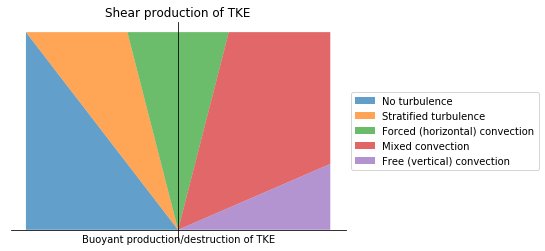

In [210]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots()
ax.fill_between([-5,0],[5,0],[0,0],label='No turbulence',alpha=0.7)
ax.fill_between([0,-5/3.,-5],[0,5,5],[0,5/3.,5],label='Stratified turbulence',alpha=0.7)
ax.fill_between([-5/3.,0,5/3.],[5,5,5],[5,0,5],label='Forced (horizontal) convection',alpha=0.7)
ax.fill_between([0,5/3.,5],[0,5,5],[0,5/9.,5/3.],label='Mixed convection',alpha=0.7)
ax.fill_between([0,5],[0,5/3.],[0,0],label='Free (vertical) convection',alpha=0.7)
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['top'].set_color('none')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel('Buoyant production/destruction of TKE')
ax.set_title('Shear production of TKE')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

Approximate regimes of free and forced convection. Reproduced from Stull, 1988, figure 5.7

### The Obukhov Length
Can be found by making the TKE tendency equation dimensionless. Multiply by $\frac{-\kappa z}{u_*^2}$ and assume that the fluxes are constant with height, i.e. equal to their surface value (approximately valid for the surface layer). The buoyancy term becomes

$$
-\frac{\kappa g z}{u_*^3 \overline{\theta_v}}(\overline{w'\theta_v'})_s
$$

leading to 
$$
L = \frac{u_*^3 \overline{\theta_v}}{\kappa g (\overline{w'\theta_v'})_s}
$$

Stull: The parameter $z/L$ (...) is sometimes called a stability parameter, although its magnitude is not directly related to static nor dynamic stability. (...) A better description of $z/L$ is "a surface-layer scaling parameter."

The idea of the surface layer or constant-flux layer is that the flux is constant with height. This is in reality not the case. Typically, it is accepted that the flux may vary by 10% with height. 

### The Brunt-Vaisala frequency
The frequency at which a displaced air parcel will oscillate when displaced vertically within a statically stable environment

$$
N = \left(\frac{g}{\theta_{va}}\frac{\partial \theta_{va}}{\partial z}\right)^\frac{1}{2}
$$

Equals zero for statically neutral air and is not defined for statically unstable air. Sometimes used as a measure of the stability within a statically stable environment.

## Analyzing WRF output
### Which variables do we have

In [233]:
import xarray as xr
wrfout = xr.open_dataset('/home/peter/Cartesius/wrfout_d01_2013-07-22_12:00:00')
for term in ['QBUOY','QSHEAR','QDISS','QWT','QKE','DTKE','TKE_PBL','EL_PBL','UST','HFX','QFX','LH']:
    print wrfout[term]

<xarray.DataArray 'QBUOY' (Time: 37, bottom_top_stag: 91, south_north: 112, west_east: 112)>
[42235648 values with dtype=float32]
Coordinates:
    XLAT     (Time, south_north, west_east) float32 44.24 44.2613 44.2821 ...
    XLONG    (Time, south_north, west_east) float32 -7.74066 -7.54221 ...
    XTIME    (Time) datetime64[ns] 2013-07-22T12:00:00 ...
Dimensions without coordinates: Time, bottom_top_stag, south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XYZ
    description:  TKE Production - buoyancy
    units:        m2 s-2
    stagger:      Z
<xarray.DataArray 'QSHEAR' (Time: 37, bottom_top_stag: 91, south_north: 112, west_east: 112)>
[42235648 values with dtype=float32]
Coordinates:
    XLAT     (Time, south_north, west_east) float32 44.24 44.2613 44.2821 ...
    XLONG    (Time, south_north, west_east) float32 -7.74066 -7.54221 ...
    XTIME    (Time) datetime64[ns] 2013-07-22T12:00:00 ...
Dimensions without coordinates: Time, bottom_top_stag, south_north, 

### What are the contributions of each term to the total TKE tendency?
We focus on the IJmuiden location for now

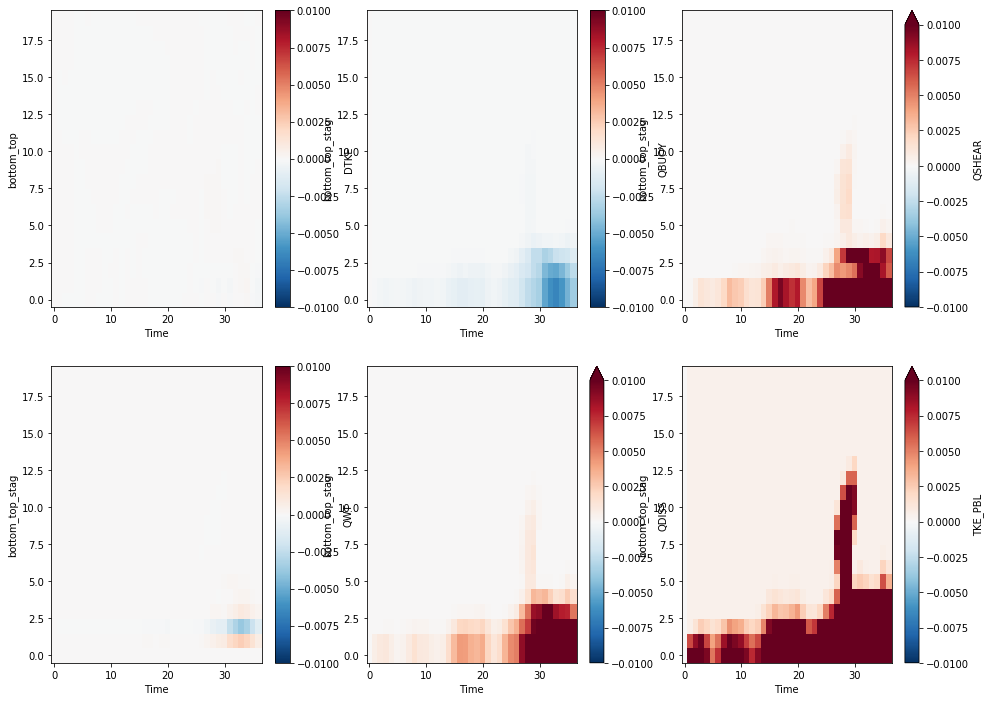

In [54]:
from netCDF4 import Dataset
import wrf as ncar
import xarray as xr
import matplotlib.pyplot as plt

# Use wrfpython to get the right cells
lat = 52.8482
lon = 3.43567
wrffile = '/home/peter/Cartesius/wrfout_d01_2013-07-22_12:00:00'
wrfout_ncar = Dataset(wrffile)
x,y = ncar.ll_to_xy(wrfout_ncar,meta=False,latitude=lat,longitude=lon)

# Now use xarray to read the data for one location
wrfout = xr.open_dataset(wrffile).sel(west_east=x,south_north=y,bottom_top=range(20),
                                      west_east_stag=x,south_north_stag=y,bottom_top_stag=range(20))

# Inspect the budget terms
fig,ax = plt.subplots(2,3,figsize=(16,12))
wrfout.DTKE.T.plot(ax=ax[0,0],vmin=-0.01,vmax=0.01,cmap='RdBu_r')
wrfout.QBUOY.T.plot(ax=ax[0,1],vmin=-0.01,vmax=0.01,cmap='RdBu_r')
wrfout.QSHEAR.T.plot(ax=ax[0,2],vmin=-0.01,vmax=0.01,cmap='RdBu_r')
wrfout.QWT.T.plot(ax=ax[1,0],vmin=-0.01,vmax=0.01,cmap='RdBu_r')
wrfout.QDISS.T.plot(ax=ax[1,1],vmin=-0.01,vmax=0.01,cmap='RdBu_r')
wrfout.TKE_PBL.T.plot(ax=ax[1,2],vmin=-0.01,vmax=0.01,cmap='RdBu_r')
plt.show()

### Does it add up?
It seems the budget doesn't add up. Note that we don't have the advection and pressure correlation terms... Inspection of the MYNN PBL module in WRF reveals that the TKE budget terms that are written to the output are just calculated for diagnostic purposes; they are not actually used. The calculation of TKE tendency is a bit obscure... Further inspection below

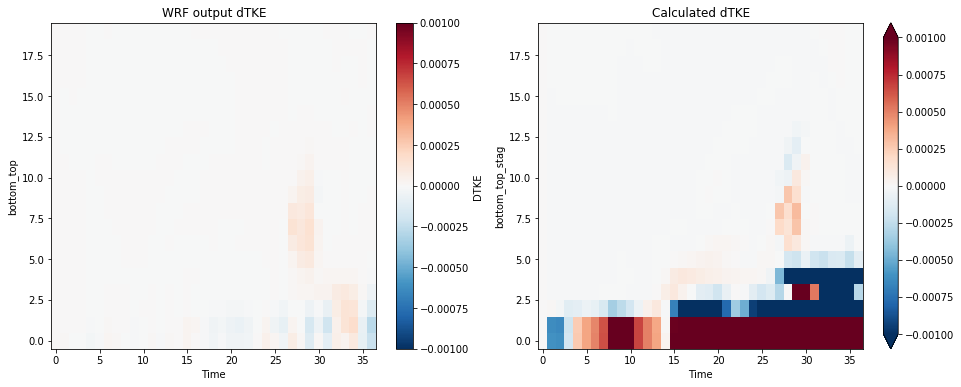

In [139]:
# Inspect the budget terms
fig,ax = plt.subplots(1,2,figsize=(16,6))
wrfout.DTKE.T.plot(ax=ax[0],vmin=-0.001,vmax=0.001,cmap='RdBu_r')
(wrfout.QBUOY+wrfout.QSHEAR-wrfout.QDISS-wrfout.QWT).T.plot(ax=ax[1],vmin=-0.001,vmax=0.001,cmap='RdBu_r')
ax[0].set_title('WRF output dTKE')
ax[1].set_title('Calculated dTKE')
plt.show()

### Missing advection?
It seems our tendency terms more or less reproduce the TKE tendency at some altitude, but near the surface they are very crude..

### Let's inspect the wind and potential temperature fields

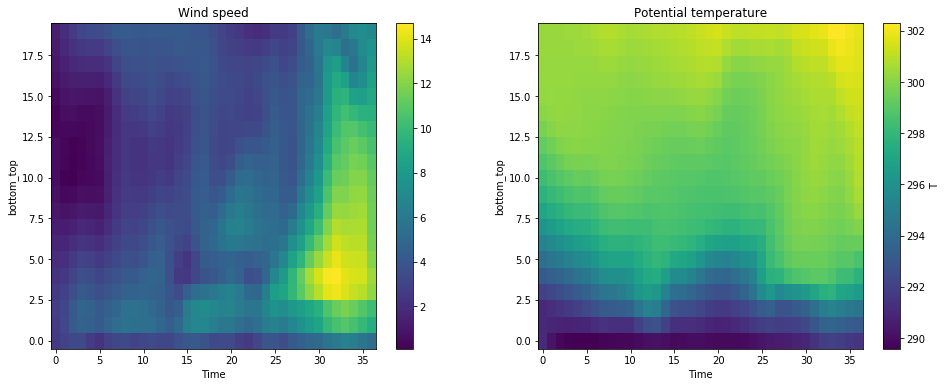

In [136]:
# Inspect shear and stratification
fig,ax = plt.subplots(1,2,figsize=(16,6))
((wrfout.U**2+wrfout.V**2)**.5).T.plot(ax=ax[0]);ax[0].set_title('Wind speed')
(wrfout['T']+300).T.plot(ax=ax[1]); ax[1].set_title('Potential temperature')
plt.show()

### Flux versus bulk Richardson numbers
We can verify the TKE tendency terms by comparing the flux richardson number with the bulk richardson number.

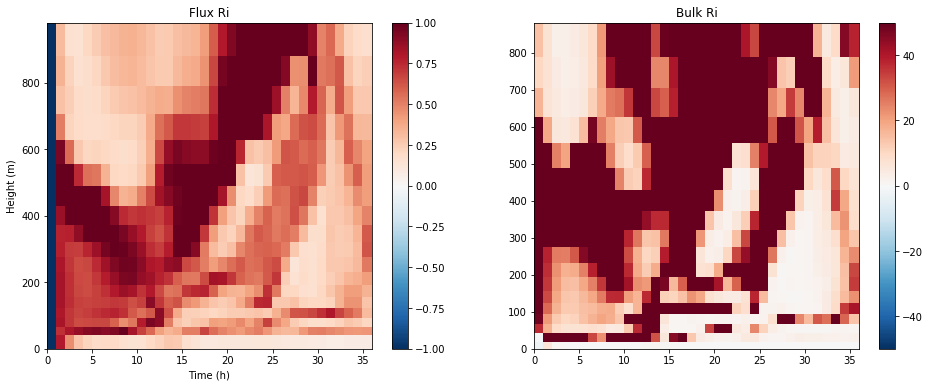

In [148]:
# Compute flux Richardson number
Ri_f = wrfout.QBUOY/-wrfout.QSHEAR

# Compute bulk Richardson number
u = (wrfout.U**2+wrfout.V**2)**.5
t = wrfout['T']+300
z = (wrfout.PH+wrfout.PHB)/9.81
du = u.diff(dim='bottom_top')
dt = t.diff(dim='bottom_top')
dz = z.diff(dim='bottom_top')
Ri_b = 9.81/t[:,1:]*dt.values*dz[:,1:].values/du**2

# Plot it
fig,ax = plt.subplots(1,2,figsize=(16,6))
rif = ax[0].pcolormesh(Ri_f.Time,z.mean(dim='Time'),Ri_f.T,vmin=-1,vmax=1,cmap='RdBu_r')
plt.colorbar(rif,ax=ax[0])
rib = ax[1].pcolormesh(Ri_b.Time,z[:,:-1].mean(dim='Time'),Ri_b.T,vmin=-50,vmax=50,cmap='RdBu_r')
plt.colorbar(rib,ax=ax[1])

ax[0].set_title('Flux Ri')
ax[1].set_title('Bulk Ri')
ax[0].set_xlabel('Time (h)')
ax[0].set_ylabel('Height (m)')
plt.show()

### TKE budget profiles
We can visualize the contribution of each TKE budget term at a given point in time by comparing profiles. This might help to give some insight into their interplay (similar figures have been presented in Stull).

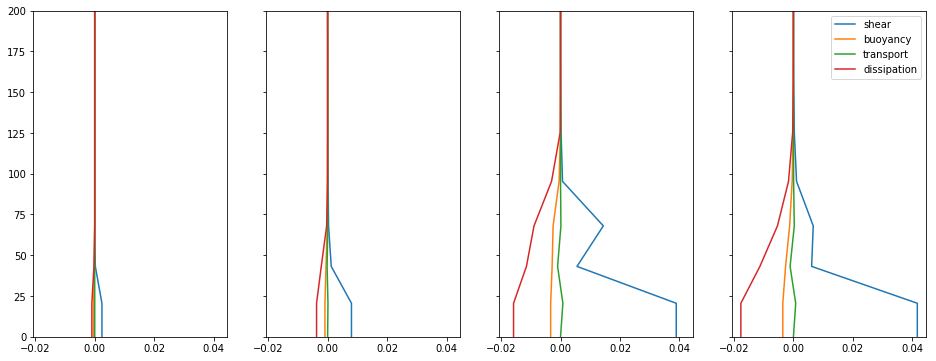

In [184]:
def plot_terms(ax,t):
    heights = z.mean(dim='Time')
    a, = ax.plot(wrfout.QSHEAR.sel(Time=t),heights,label='shear')
    b, = ax.plot(wrfout.QBUOY.sel(Time=t),heights,label='buoyancy')
    c, = ax.plot(wrfout.QWT.sel(Time=t),heights,label='transport')
    d, = ax.plot(-wrfout.QDISS.sel(Time=t),heights,label='dissipation')
    return 

fig,axs = plt.subplots(1,4,figsize=(16,6),sharex=True,sharey=True)
for ax,t in zip(axs.flat,[10,20,30,36]): 
    plot_terms(ax,t=t)
    
axs[3].set_ylim(0,200)    
axs[3].legend()
plt.show()

### Checking the turbulence regime. 
Recall the conceptual figure from the top of this notebook. Let's see how our model fits in this conceptual frame

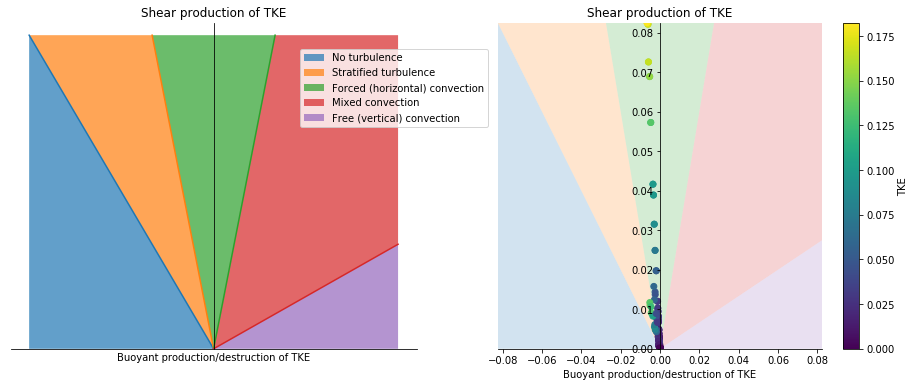

In [232]:
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(16,6))

# First illustrative figure from Stull
ax1.fill_between([-5,0],[5,0],[0,0],label='No turbulence',alpha=0.7)
ax1.fill_between([0,-5/3.,-5],[0,5,5],[0,5/3.,5],label='Stratified turbulence',alpha=0.7)
ax1.fill_between([-5/3.,0,5/3.],[5,5,5],[5,0,5],label='Forced (horizontal) convection',alpha=0.7)
ax1.fill_between([0,5/3.,5],[0,5,5],[0,5/9.,5/3.],label='Mixed convection',alpha=0.7)
ax1.fill_between([0,5],[0,5/3.],[0,0],label='Free (vertical) convection',alpha=0.7)

ax1.plot([-5,0],[5,0])
ax1.plot([-5/3.,0],[5,0])
ax1.plot([0,5/3.],[0,5])
ax1.plot([0,5],[0,5/3.])

ax1.spines['left'].set_position('zero')
ax1.spines['right'].set_color('none')
ax1.spines['bottom'].set_position('zero')
ax1.spines['top'].set_color('none')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel('Buoyant production/destruction of TKE')
ax1.set_title('Shear production of TKE')
ax1.legend(loc='center left', bbox_to_anchor=(.7, 0.8))
ax1.set_ylim(0,5.2)

# Now with real data
ax2.fill_between([-5,0],[5,0],[0,0],label='No turbulence',alpha=0.2)
ax2.fill_between([0,-5/3.,-5],[0,5,5],[0,5/3.,5],label='Stratified turbulence',alpha=0.2)
ax2.fill_between([-5/3.,0,5/3.],[5,5,5],[5,0,5],label='Forced (horizontal) convection',alpha=0.2)
ax2.fill_between([0,5/3.,5],[0,5,5],[0,5/9.,5/3.],label='Mixed convection',alpha=0.2)
ax2.fill_between([0,5],[0,5/3.],[0,0],label='Free (vertical) convection',alpha=0.2)
ax2.spines['left'].set_position('zero')
ax2.spines['right'].set_color('none')
ax2.spines['bottom'].set_position('zero')
ax2.spines['top'].set_color('none')
ax2.set_xlabel('Buoyant production/destruction of TKE')
ax2.set_title('Shear production of TKE')

s = ax2.scatter(wrfout.QBUOY,wrfout.QSHEAR,c=wrfout.TKE_PBL)
lim = max(np.max(np.abs(wrfout.QBUOY)),np.max(np.abs(wrfout.QSHEAR)))
ax2.set_xlim(-lim,lim)
ax2.set_ylim(0,lim)
plt.colorbar(s,label='TKE')

plt.show()

### Mostly forced convection
It turns out that most of our model data is situated in the 'forced convection' regime. We see that TKE is largest for the largest shear production. It'd be interesting to compare this to other cases and other locations. Perhaps we can find some patterns...

## Next steps
This was a preliminary analysis of stability/turbulence analysis. If it is promising enough, we can think about extending it with more cases/other locations. Also, we might try to verify with observations. Additionally, LES (or DNS?) fields may help to reproduce such a conceptual figure as the last one. 

I'm mostly interested to see whether this conceptual figure differs for onshore/offshore situations and for different weather conditions. Is the blue area's extent larger offshore? Is it really justified to neglect the other terms in the TKE budget equation in order to compute a simple Richardson number? Or are they not negligible and does Ri a give misleading picture? And can we somehow find a better measure of stability/turbulence regime?